# Notebook to plot variance, mean state of d18O as well as correlations with other variables, monthly and yearly timescale.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import netCDF4
import math
import numpy as np
matplotlib.rcParams['figure.figsize'] = (14.0, 10.0)
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import scipy

import re
from datetime import datetime

from mpl_toolkits.axes_grid1 import make_axes_locatable

# from sklearn.model_selection import train_test_split

In [2]:
DATASET_FOLDER = "Datasets/Original/"

dataset_iso = netCDF4.Dataset(DATASET_FOLDER + 'xnapa_isotopes.nc', "a")
dataset_precip = netCDF4.Dataset(DATASET_FOLDER + 'xnapa_precip.nc', "a")
dataset_tas = netCDF4.Dataset(DATASET_FOLDER + 'xnapa_temp.nc', "a")
dataset_slp = netCDF4.Dataset(DATASET_FOLDER + 'xnapa_slp.nc', "a")

datasets = {'dO18' : dataset_iso, 'precip' : dataset_precip, 'temp_1' : dataset_tas,'p' : dataset_slp}
# this will be used later to automatically extract info about the target var:
datasetname = "dO18"

In [3]:
# names of datasets to which we want not to be missing at any timestep.

def get_shared_timesteps_indices(dsets):
    """
    Not all datasets share the same timesteps. The biggest problems occur in the slp dataset. We want to exclude all
    time steps where one of the variables is missing
    """
    # get indices of elements that are shared for all variables.
    from functools import reduce
    ts = tuple([dataset.variables["t"][:].data for dataset in dsets.values()])
    common_dates = reduce(np.intersect1d, ts)
    
    indices = []
    for dataset in dsets.values():
        # get the corresponding indices:
        indices.append([])
        for i, t in enumerate(dataset.variables["t"][:].data):
            if t in common_dates:
                indices[-1].append(i)
        indices[-1] = np.delete(indices[-1], 0) # remove index 0 if in array.
        index_mask = (dataset.variables["t"][indices[-1]].data <= 1000*360 + dataset.variables["t"][0].data)
        indices[-1] = indices[-1][index_mask]
    return indices

In [4]:
ids = get_shared_timesteps_indices(datasets)
i_dict = dict(zip(datasets.keys(),ids))

In [5]:
# days = np.arange(len(time))
# datasetname = 'PI_prw'

lat = datasets["dO18"].variables["latitude"][:].data[1:-1]
lon = datasets["dO18"].variables["longitude"][:].data

t = datasets["temp_1"].variables["t"][i_dict["temp_1"]].data

In [6]:

# somehow two frames are excluded - why???? -> the dO18 datset is 2 timesteps smaller, but the time
# axis actually has the same size...


#import the precipitation, reshape and remove the points at north and south pole
pr = np.squeeze(datasets["precip"].variables["precip"][:].data)[:,1:-1,:]
tas = np.squeeze(datasets["temp_1"].variables["temp_1"][:].data)[:,1:-1,:]
slp = np.squeeze(datasets["p"].variables["p"][:].data)[:,1:-1,:]

dO18 = np.squeeze(datasets["dO18"].variables["dO18"][:].data)[:,1:-1,:]

#exclude timesteps that are not shared amongst all simulations
dO18 = dO18[i_dict["dO18"],:,:]
pr = pr[i_dict["precip"],:,:]
tas = tas[i_dict["temp_1"],:,:]
slp = slp[i_dict["p"],:,:]

In [7]:
def RMSE(predictions, targets):
    from sklearn.metrics import mean_squared_error
    rmse = np.zeros((predictions.shape[1]))
    for i in range(predictions.shape[1]):
        rmse[i] = mean_squared_error(targets[:,i], predictions[:,i], squared=False)
    return rmse

def cor_fields(field_1, field_2):
    """Calculate pearson correlation coefficient for temporal correlation of 2 spatiotemporal fields"""
    assert (len(field_1.shape) == 2 or len(field_1.shape) == 3) and (len(field_2.shape) == 2 or len(field_2.shape) == 3)
    
    if len(field_1.shape) == 2:
        f1 = field_1.reshape(-1,len(lat),len(lon))
    else: 
        f1 = field_1
    if len(field_2.shape) == 2:  
        f2 = field_2.reshape(-1,len(lat),len(lon))
    else:
        f2 = field_2
        
    from scipy.stats import pearsonr 
    pearson_correlation = np.zeros((f1.shape[1],f1.shape[2]))
    for i in range(f1.shape[1]):
        for j in range(f1.shape[2]):
            pearson_correlation[i,j] = pearsonr(f1[:,i,j],f2[:,i,j])[0]
    return pearson_correlation

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    import matplotlib.colors as colors
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [8]:
cor_pr_dO18 = cor_fields(pr, dO18)
cor_tas_dO18 = cor_fields(tas, dO18)
cor_slp_dO18 = cor_fields(slp, dO18)

In [9]:
# idea: For each gridbox check how big the biggest abs correlation is

max_cor = np.amax([abs(cor_pr_dO18),abs(cor_tas_dO18),abs(cor_slp_dO18)], axis=0)
argmax_cor = np.argmax([abs(cor_pr_dO18),abs(cor_tas_dO18),abs(cor_slp_dO18)],axis=0)

min_cor = 0.0
tas_mask = np.where(((argmax_cor == 1)&(max_cor > min_cor)),True,False)
pr_mask = np.where(((argmax_cor == 0)&(max_cor > min_cor)),True,False)
slp_mask = np.where(((argmax_cor == 2)&(max_cor > min_cor)),True,False)

not_incl_mask = np.invert(tas_mask + pr_mask + slp_mask)

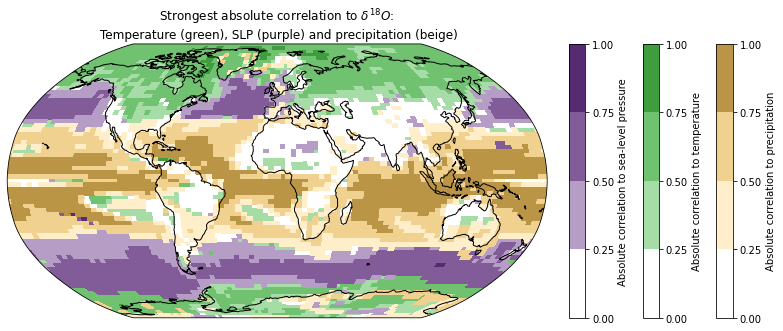

In [10]:
from numpy.ma import masked_array
  

# masked array to positive and negative values
tas_img = masked_array(max_cor, np.invert(tas_mask))
pr_img = masked_array(max_cor, np.invert(pr_mask))
slp_img = masked_array(max_cor, np.invert(slp_mask))
zero_img = masked_array(np.zeros_like(max_cor), np.invert(not_incl_mask))
  
# make plot
fig = plt.figure(figsize=(13,20))
ax = fig.add_subplot(111, projection = ccrs.Robinson())
ax.set_global()
# show image

cor_tas_field, lon_plot = add_cyclic_point(tas_img, coord = lon)
cor_pr_field, lon_plot = add_cyclic_point(pr_img, coord = lon)
cor_slp_field, lon_plot = add_cyclic_point(slp_img, coord = lon)
cor_zero_field, lon_plot = add_cyclic_point(zero_img, coord = lon)

lo, la = np.meshgrid(lon_plot, lat)
norm = matplotlib.colors.BoundaryNorm(np.linspace(0,1,5), 4)

colors_tas = ["#fff", "#A6DCA6", "#70C170", "#3E9E3E"]#, "#1E7F1E"]
cmap_tas= matplotlib.colors.ListedColormap(colors_tas)

colors_pr = ["#fff", "#FFEECA", "#F0D18F", "#BA9545"]#, "#866113"]
cmap_pr= matplotlib.colors.ListedColormap(colors_pr)

colors_slp = ["#fff", "#B59DC5", "#815C99", "#562B71"]#, "#2C0842"]
cmap_slp= matplotlib.colors.ListedColormap(colors_slp)

layer_tas = ax.pcolormesh(lo, la, cor_tas_field, transform=ccrs.PlateCarree(), cmap=cmap_tas, norm=norm)   
layer_slp = ax.pcolormesh(lo, la, cor_slp_field, transform=ccrs.PlateCarree(), cmap=cmap_slp, norm=norm)  
layer_pr = ax.pcolormesh(lo, la, cor_pr_field, transform=ccrs.PlateCarree(), cmap=cmap_pr, norm=norm)    
# layer_zero = ax.pcolormesh(lo, la, cor_zero_field, transform=ccrs.PlateCarree(), cmap=plt.cm.Greens, norm=norm)    
  

    
divider = make_axes_locatable(ax)


ax_cb1 = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
fig.add_axes(ax_cb1)
bar_slp = fig.colorbar(layer_slp, cax= ax_cb1, orientation='vertical')

ax_cb2 = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)
fig.add_axes(ax_cb2)
bar_tas = fig.colorbar(layer_tas, cax= ax_cb2, orientation='vertical')

ax_cb3 = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)
fig.add_axes(ax_cb3)
bar_pr = fig.colorbar(layer_pr, cax= ax_cb3, orientation='vertical')

bar_tas.set_label('Absolute correlation to temperature')
bar_pr.set_label('Absolute correlation to precipitation')
bar_slp.set_label('Absolute correlation to sea-level pressure')
ax.set_title("Strongest absolute correlation to $\delta^{18}O$: \n Temperature (green), SLP (purple) and precipitation (beige)")
ax.coastlines()
plt.savefig("Images/Correlations.png")
plt.savefig("Images/Correlations.pdf")
plt.savefig("Images/Correlations.jpg")
plt.show()
plt.close()

In [11]:
# extract correlation at some ice core drilling stations.

In [12]:
# from other notebook...
i_lat_wais_divide = 67
i_lon_wais_divide = 66

i_lat_ngrip = 5
i_lon_ngrip = 85

i_lat_kohnen = 65
i_lon_kohnen = 33

i_lat_dome_c = 65
i_lon_dome_c = 0

In [13]:
print("correlation of T and d18O at NGRIP", "{:.2f}".format(cor_tas_dO18[i_lat_ngrip, i_lon_ngrip]))
print("correlation of precip and d18O at NGRIP", "{:.2f}".format(cor_pr_dO18[i_lat_ngrip, i_lon_ngrip]))
print("correlation of slp and d18O at NGRIP", "{:.2f}".format(cor_slp_dO18[i_lat_ngrip, i_lon_ngrip]))

print()

print("correlation of T and d18O at WAIS", "{:.2f}".format(cor_tas_dO18[i_lat_wais_divide, i_lon_wais_divide]))
print("correlation of precip and d18O at WAIS", "{:.2f}".format(cor_pr_dO18[i_lat_wais_divide, i_lon_wais_divide]))
print("correlation of slp and d18O at WAIS", "{:.2f}".format(cor_slp_dO18[i_lat_wais_divide, i_lon_wais_divide]))

print()

print("correlation of T and d18O at Dome C", "{:.2f}".format(cor_tas_dO18[i_lat_dome_c, i_lon_dome_c]))
print("correlation of precip and d18O at Dome C", "{:.2f}".format(cor_pr_dO18[i_lat_dome_c, i_lon_dome_c]))
print("correlation of slp and d18O at Dome C", "{:.2f}".format(cor_slp_dO18[i_lat_dome_c, i_lon_dome_c]))

print()

print("correlation of T and d18O at Kohnen", "{:.2f}".format(cor_tas_dO18[i_lat_kohnen, i_lon_kohnen]))
print("correlation of precip and d18O at Kohnen", "{:.2f}".format(cor_pr_dO18[i_lat_kohnen, i_lon_kohnen]))
print("correlation of slp and d18O at Kohnen", "{:.2f}".format(cor_slp_dO18[i_lat_kohnen, i_lon_kohnen]))

correlation of T and d18O at NGRIP 0.62
correlation of precip and d18O at NGRIP 0.38
correlation of slp and d18O at NGRIP 0.12

correlation of T and d18O at WAIS 0.69
correlation of precip and d18O at WAIS 0.64
correlation of slp and d18O at WAIS 0.41

correlation of T and d18O at Dome C 0.29
correlation of precip and d18O at Dome C 0.28
correlation of slp and d18O at Dome C 0.25

correlation of T and d18O at Kohnen 0.53
correlation of precip and d18O at Kohnen 0.45
correlation of slp and d18O at Kohnen 0.32


In [14]:
mean_state = np.mean(dO18,axis=0)
std = np.std(dO18, axis=0)

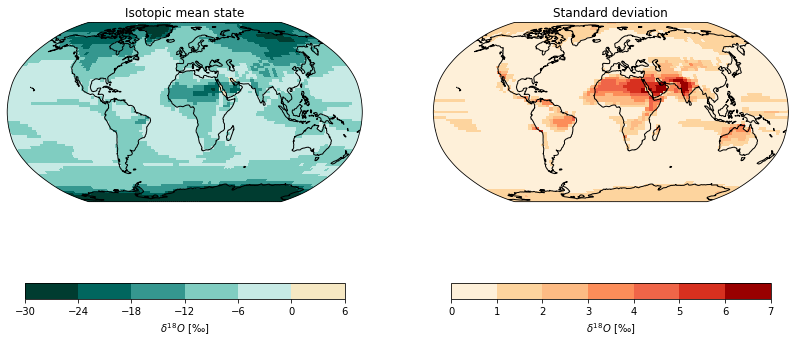

In [15]:
colors_mean = ["#003c30","#01665e","#35978f","#80cdc1","#c7eae5","#f6e8c3"]#"#dfc27d","#bf812d","#8c510a","#003c30"
cmap_mean = matplotlib.colors.ListedColormap(colors_mean)
bounds_mean = np.linspace(-30,6,7)
norm_mean = matplotlib.colors.BoundaryNorm(bounds_mean, 6)

colors_std = ["#fef0d9","#fdd49e","#fdbb84","#fc8d59","#ef6548","#d7301f","#990000"]
cmap_std = matplotlib.colors.ListedColormap(colors_std)
bounds_std = np.linspace(0,7,8)
norm_std = matplotlib.colors.BoundaryNorm(bounds_std, 7)


# make plot
fig = plt.figure()
spec = fig.add_gridspec(ncols=2, nrows=1)
ax = fig.add_subplot(spec[0,0], projection = ccrs.Robinson())

mean_field, lon_plot = add_cyclic_point(mean_state, coord = lon)
lo, la = np.meshgrid(lon_plot, lat)
layer_mean = ax.pcolormesh(lo, la, mean_field, transform=ccrs.PlateCarree(), cmap=cmap_mean, norm=norm_mean)   
cbar_mean = plt.colorbar(layer_mean, shrink=0.9, orientation="horizontal", ax=ax) 
cbar_mean.set_label(r'$\delta^{18}O$ [‰]')
ax.set_title("Isotopic mean state")
ax.coastlines()


ax2 = fig.add_subplot(spec[0,1], projection = ccrs.Robinson())

std_field, lon_plot = add_cyclic_point(std, coord = lon)
lo, la = np.meshgrid(lon_plot, lat)
layer_std = ax2.pcolormesh(lo, la, std_field, transform=ccrs.PlateCarree(), cmap=cmap_std, norm=norm_std)   
cbar_std = plt.colorbar(layer_std, shrink=0.9, orientation="horizontal", ax=ax2) 
cbar_std.set_label(r'$\delta^{18}O$ [‰]')
ax2.set_title("Standard deviation")
ax2.coastlines()


plt.savefig("Images/Mean_std.png")
plt.savefig("Images/Mean_std.pdf")
plt.savefig("Images/Mean_std.jpg")
plt.show()
plt.close()

In [16]:
colors_std = ["#fef0d9","#fdd49e","#fdbb84","#fc8d59","#ef6548","#d7301f","#990000"]

cmap_std = matplotlib.colors.ListedColormap(colors_std)

# make plot
fig = plt.figure()

plt.savefig("Images/Standard_deviation.png")
plt.savefig("Images/Standard_deviation.pdf")
plt.savefig("Images/Standard_deviation.jpg")
plt.show()
plt.close()

<Figure size 1008x720 with 0 Axes>

## compute correlations between d18O and predictor variables for months.

In [17]:
import pandas as pd

In [18]:
DATASET_FOLDER = "Datasets/Original/"

dataset_iso = netCDF4.Dataset(DATASET_FOLDER + 'xnapa_monthly_isotopes.nc', "a")
dataset_precip = netCDF4.Dataset(DATASET_FOLDER + 'xnapa_monthly_precip.nc', "a")
dataset_tas = netCDF4.Dataset(DATASET_FOLDER + 'xnapa_monthly_temp.nc', "a")
dataset_slp = netCDF4.Dataset(DATASET_FOLDER + 'xnapa_monthly_slp.nc', "a")

datasets = {'dO18' : dataset_iso, 'precip' : dataset_precip, 'temp_1' : dataset_tas,'p' : dataset_slp}
# this will be used later to automatically extract info about the target var:
datasetname = "dO18"

In [19]:
ids = get_shared_timesteps_indices(datasets)
i_dict = dict(zip(datasets.keys(),ids))

In [20]:
# days = np.arange(len(time))
# datasetname = 'PI_prw'

lat = datasets["dO18"].variables["latitude"][:].data[1:-1]
lon = datasets["dO18"].variables["longitude"][:].data

t = datasets["temp_1"].variables["t"][i_dict["temp_1"]].data

In [21]:
#import the precipitation, reshape and remove the points at north and south pole
pr = np.squeeze(datasets["precip"].variables["precip"][:].data)[:,1:-1,:]
tas = np.squeeze(datasets["temp_1"].variables["temp_1"][:].data)[:,1:-1,:]
slp = np.squeeze(datasets["p"].variables["p"][:].data)[:,1:-1,:]

dO18 = np.squeeze(datasets["dO18"].variables["dO18"][:].data)[:,1:-1,:]

#exclude timesteps that are not shared amongst all simulations
dO18 = dO18[i_dict["dO18"],:,:]
pr = pr[i_dict["precip"],:,:]
tas = tas[i_dict["temp_1"],:,:]
slp = slp[i_dict["p"],:,:]

In [22]:
cor_pr = np.zeros((dO18.shape[1], dO18.shape[2]))
cor_tas = np.zeros((dO18.shape[1], dO18.shape[2]))
cor_slp = np.zeros((dO18.shape[1], dO18.shape[2]))

for i in range(dO18.shape[1]):
    for j in range(dO18.shape[2]):
        df = pd.DataFrame({"dO18": dO18[...,i,j],
                           "pr": pr[...,i,j],
                           "tas": tas[...,i,j],
                           "slp": slp[...,i,j]})
        cor = df.corr()
        cor_pr[i,j] = cor["dO18"]["pr"]
        cor_tas[i,j] = cor["dO18"]["tas"]
        cor_slp[i,j] = cor["dO18"]["slp"]

In [23]:
# idea: For each gridbox check how big the biggest abs correlation is

max_cor = np.amax([abs(cor_pr),abs(cor_tas),abs(cor_slp)], axis=0)
argmax_cor = np.argmax([abs(cor_pr),abs(cor_tas),abs(cor_slp)],axis=0)

min_cor = 0.0
tas_mask = np.where(((argmax_cor == 1)&(max_cor > min_cor)),True,False)
pr_mask = np.where(((argmax_cor == 0)&(max_cor > min_cor)),True,False)
slp_mask = np.where(((argmax_cor == 2)&(max_cor > min_cor)),True,False)

not_incl_mask = np.invert(tas_mask + pr_mask + slp_mask)

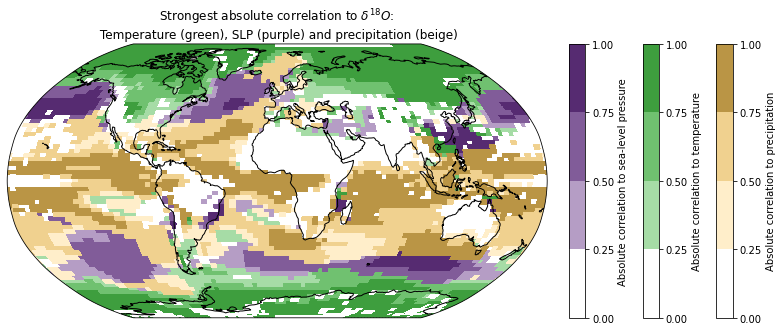

In [24]:
from numpy.ma import masked_array
  

# masked array to positive and negative values
tas_img = masked_array(max_cor, np.invert(tas_mask))
pr_img = masked_array(max_cor, np.invert(pr_mask))
slp_img = masked_array(max_cor, np.invert(slp_mask))
zero_img = masked_array(np.zeros_like(max_cor), np.invert(not_incl_mask))
  
# make plot
fig = plt.figure(figsize=(13,20))
ax = fig.add_subplot(111, projection = ccrs.Robinson())
ax.set_global()
# show image

cor_tas_field, lon_plot = add_cyclic_point(tas_img, coord = lon)
cor_pr_field, lon_plot = add_cyclic_point(pr_img, coord = lon)
cor_slp_field, lon_plot = add_cyclic_point(slp_img, coord = lon)
cor_zero_field, lon_plot = add_cyclic_point(zero_img, coord = lon)

lo, la = np.meshgrid(lon_plot, lat)
norm = matplotlib.colors.BoundaryNorm(np.linspace(0,1,5), 4)

colors_tas = ["#fff", "#A6DCA6", "#70C170", "#3E9E3E"]#, "#1E7F1E"]
cmap_tas= matplotlib.colors.ListedColormap(colors_tas)

colors_pr = ["#fff", "#FFEECA", "#F0D18F", "#BA9545"]#, "#866113"]
cmap_pr= matplotlib.colors.ListedColormap(colors_pr)

colors_slp = ["#fff", "#B59DC5", "#815C99", "#562B71"]#, "#2C0842"]
cmap_slp= matplotlib.colors.ListedColormap(colors_slp)

layer_tas = ax.pcolormesh(lo, la, cor_tas_field, transform=ccrs.PlateCarree(), cmap=cmap_tas, norm=norm)   
layer_slp = ax.pcolormesh(lo, la, cor_slp_field, transform=ccrs.PlateCarree(), cmap=cmap_slp, norm=norm)  
layer_pr = ax.pcolormesh(lo, la, cor_pr_field, transform=ccrs.PlateCarree(), cmap=cmap_pr, norm=norm)    
# layer_zero = ax.pcolormesh(lo, la, cor_zero_field, transform=ccrs.PlateCarree(), cmap=plt.cm.Greens, norm=norm)    
  

    
divider = make_axes_locatable(ax)


ax_cb1 = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
fig.add_axes(ax_cb1)
bar_slp = fig.colorbar(layer_slp, cax= ax_cb1, orientation='vertical')

ax_cb2 = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)
fig.add_axes(ax_cb2)
bar_tas = fig.colorbar(layer_tas, cax= ax_cb2, orientation='vertical')

ax_cb3 = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)
fig.add_axes(ax_cb3)
bar_pr = fig.colorbar(layer_pr, cax= ax_cb3, orientation='vertical')

bar_tas.set_label('Absolute correlation to temperature')
bar_pr.set_label('Absolute correlation to precipitation')
bar_slp.set_label('Absolute correlation to sea-level pressure')
ax.set_title("Strongest absolute correlation to $\delta^{18}O$: \n Temperature (green), SLP (purple) and precipitation (beige)")
ax.coastlines()
plt.savefig("Images/Correlations_monthly.png")
plt.savefig("Images/Correlations_monthly.pdf")
plt.savefig("Images/Correlations_monthly.jpg")
plt.show()
plt.close()

In [25]:
def get_indices_months(indices_dict, selected_months):
    ### split into months.
    new_dict = {}
    for name, i_array in indices_dict.items():
        t = datasets[name].variables["t"][:].data
        t_0 = t[0]
        match = re.search(r'\d{4}-\d{2}-\d{2}', datasets[name].variables["t"].units)
        if match is None:
            raise ValueError("No date following the YYY-MM-DD convention found")

        ref_date = datetime.strptime(match.group(), '%Y-%m-%d').date()

        ref_year = ref_date.year
        ref_month = ref_date.month - 1  # months in calendar 1-12, we want 0-11
        ref_day = ref_date.day

        d_year = t_0 // 360
        d_month = (t_0 - d_year*360) // 30
        d_day = (t_0 - d_year*360 - d_month*30) // 1

        d_0 = (ref_day + d_day) % 30
        m_0 = (ref_month + d_month + (ref_day+d_day)//30) % 12
        y_0 = ref_year + d_year + (ref_month + d_month + (ref_day+d_day)//30)//12
        assert d_0 == 16

        months_indices = []
        for i in selected_months:
            months_indices.append(np.where(t%360 == (t_0 + 30*(i-m_0))%360)[0])
        months_indices = np.concatenate(months_indices).flatten()
        months_indices = np.intersect1d(i_array, months_indices)
        new_dict[name] = months_indices
    return new_dict

In [26]:
#import the precipitation, reshape and remove the points at north and south pole
pr = np.squeeze(datasets["precip"].variables["precip"][:].data)[:,1:-1,:]
tas = np.squeeze(datasets["temp_1"].variables["temp_1"][:].data)[:,1:-1,:]
slp = np.squeeze(datasets["p"].variables["p"][:].data)[:,1:-1,:]
dO18 = np.squeeze(datasets["dO18"].variables["dO18"][:].data)[:,1:-1,:]


sel_months = [11,0,1]
i_sel_months_dict = get_indices_months(i_dict, sel_months)

#exclude timesteps that are not shared amongst all simulations
dO18_djf = dO18[i_sel_months_dict["dO18"],:,:]
pr_djf = pr[i_sel_months_dict["precip"],:,:]
tas_djf = tas[i_sel_months_dict["temp_1"],:,:]
slp_djf = slp[i_sel_months_dict["p"],:,:]

sel_months = [5,6,7]
i_sel_months_dict = get_indices_months(i_dict, sel_months)

#exclude timesteps that are not shared amongst all simulations
dO18_jas = dO18[i_sel_months_dict["dO18"],:,:]
pr_jas = pr[i_sel_months_dict["precip"],:,:]
tas_jas = tas[i_sel_months_dict["temp_1"],:,:]
slp_jas = slp[i_sel_months_dict["p"],:,:]

In [27]:
cor_pr_djf = np.zeros((dO18_djf.shape[1], dO18_djf.shape[2]))
cor_tas_djf = np.zeros((dO18_djf.shape[1], dO18_djf.shape[2]))
cor_slp_djf = np.zeros((dO18_djf.shape[1], dO18_djf.shape[2]))

cor_pr_jas = np.zeros((dO18_jas.shape[1], dO18_jas.shape[2]))
cor_tas_jas = np.zeros((dO18_jas.shape[1], dO18_jas.shape[2]))
cor_slp_jas = np.zeros((dO18_jas.shape[1], dO18_jas.shape[2]))

for i in range(dO18_djf.shape[1]):
    for j in range(dO18_djf.shape[2]):
        df = pd.DataFrame({"dO18": dO18_djf[...,i,j],
                           "pr": pr_djf[...,i,j],
                           "tas": tas_djf[...,i,j],
                           "slp": slp_djf[...,i,j]})
        cor = df.corr()
        cor_pr_djf[i,j] = cor["dO18"]["pr"]
        cor_tas_djf[i,j] = cor["dO18"]["tas"]
        cor_slp_djf[i,j] = cor["dO18"]["slp"]
        
for i in range(dO18_jas.shape[1]):
    for j in range(dO18_jas.shape[2]):
        df = pd.DataFrame({"dO18": dO18_jas[...,i,j],
                           "pr": pr_jas[...,i,j],
                           "tas": tas_jas[...,i,j],
                           "slp": slp_jas[...,i,j]})
        cor = df.corr()
        cor_pr_jas[i,j] = cor["dO18"]["pr"]
        cor_tas_jas[i,j] = cor["dO18"]["tas"]
        cor_slp_jas[i,j] = cor["dO18"]["slp"]

In [28]:
# idea: For each gridbox check how big the biggest abs correlation is

max_cor_djf = np.amax([abs(cor_pr_djf),abs(cor_tas_djf),abs(cor_slp_djf)], axis=0)
argmax_cor_djf = np.argmax([abs(cor_pr_djf),abs(cor_tas_djf),abs(cor_slp_djf)],axis=0)

min_cor = 0.0
tas_mask_djf = np.where(((argmax_cor_djf == 1)&(max_cor_djf > min_cor)),True,False)
pr_mask_djf = np.where(((argmax_cor_djf == 0)&(max_cor_djf > min_cor)),True,False)
slp_mask_djf = np.where(((argmax_cor_djf == 2)&(max_cor_djf > min_cor)),True,False)

not_incl_mask_djf = np.invert(tas_mask_djf + pr_mask_djf + slp_mask_djf)

# idea: For each gridbox check how big the biggest abs correlation is

max_cor_jas = np.amax([abs(cor_pr_jas),abs(cor_tas_jas),abs(cor_slp_jas)], axis=0)
argmax_cor_jas = np.argmax([abs(cor_pr_jas),abs(cor_tas_jas),abs(cor_slp_jas)],axis=0)

min_cor = 0.0
tas_mask_jas = np.where(((argmax_cor_jas == 1)&(max_cor_jas > min_cor)),True,False)
pr_mask_jas = np.where(((argmax_cor_jas == 0)&(max_cor_jas > min_cor)),True,False)
slp_mask_jas = np.where(((argmax_cor_jas == 2)&(max_cor_jas > min_cor)),True,False)

not_incl_mask_jas = np.invert(tas_mask_jas + pr_mask_jas + slp_mask_jas)

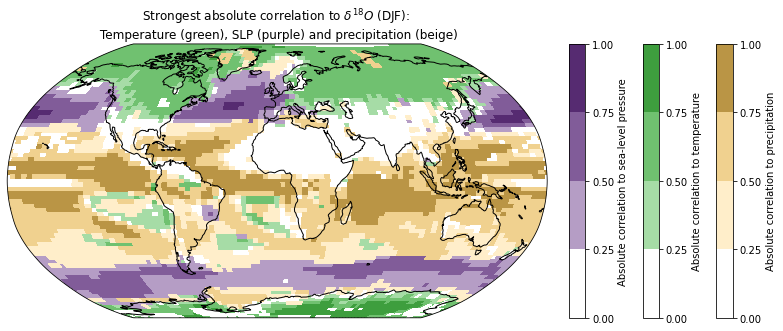

In [29]:
from numpy.ma import masked_array
  

# masked array to positive and negative values
tas_img = masked_array(max_cor_djf, np.invert(tas_mask_djf))
pr_img = masked_array(max_cor_djf, np.invert(pr_mask_djf))
slp_img = masked_array(max_cor_djf, np.invert(slp_mask_djf))
zero_img = masked_array(np.zeros_like(max_cor_djf), np.invert(not_incl_mask_djf))
  
# make plot
fig = plt.figure(figsize=(13,20))
ax = fig.add_subplot(111, projection = ccrs.Robinson())
ax.set_global()
# show image

cor_tas_field, lon_plot = add_cyclic_point(tas_img, coord = lon)
cor_pr_field, lon_plot = add_cyclic_point(pr_img, coord = lon)
cor_slp_field, lon_plot = add_cyclic_point(slp_img, coord = lon)
cor_zero_field, lon_plot = add_cyclic_point(zero_img, coord = lon)

lo, la = np.meshgrid(lon_plot, lat)
norm = matplotlib.colors.BoundaryNorm(np.linspace(0,1,5), 4)

colors_tas = ["#fff", "#A6DCA6", "#70C170", "#3E9E3E"]#, "#1E7F1E"]
cmap_tas= matplotlib.colors.ListedColormap(colors_tas)

colors_pr = ["#fff", "#FFEECA", "#F0D18F", "#BA9545"]#, "#866113"]
cmap_pr= matplotlib.colors.ListedColormap(colors_pr)

colors_slp = ["#fff", "#B59DC5", "#815C99", "#562B71"]#, "#2C0842"]
cmap_slp= matplotlib.colors.ListedColormap(colors_slp)

layer_tas = ax.pcolormesh(lo, la, cor_tas_field, transform=ccrs.PlateCarree(), cmap=cmap_tas, norm=norm)   
layer_slp = ax.pcolormesh(lo, la, cor_slp_field, transform=ccrs.PlateCarree(), cmap=cmap_slp, norm=norm)  
layer_pr = ax.pcolormesh(lo, la, cor_pr_field, transform=ccrs.PlateCarree(), cmap=cmap_pr, norm=norm)    
# layer_zero = ax.pcolormesh(lo, la, cor_zero_field, transform=ccrs.PlateCarree(), cmap=plt.cm.Greens, norm=norm)    
  

    
divider = make_axes_locatable(ax)


ax_cb1 = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
fig.add_axes(ax_cb1)
bar_slp = fig.colorbar(layer_slp, cax= ax_cb1, orientation='vertical')

ax_cb2 = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)
fig.add_axes(ax_cb2)
bar_tas = fig.colorbar(layer_tas, cax= ax_cb2, orientation='vertical')

ax_cb3 = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)
fig.add_axes(ax_cb3)
bar_pr = fig.colorbar(layer_pr, cax= ax_cb3, orientation='vertical')

bar_tas.set_label('Absolute correlation to temperature')
bar_pr.set_label('Absolute correlation to precipitation')
bar_slp.set_label('Absolute correlation to sea-level pressure')
ax.set_title("Strongest absolute correlation to $\delta^{18}O$ (DJF): \n Temperature (green), SLP (purple) and precipitation (beige)")
ax.coastlines()
plt.savefig("Images/Correlations_monthly_djf.png")
plt.savefig("Images/Correlations_monthly_djf.pdf")
plt.savefig("Images/Correlations_monthly_djf.jpg")
plt.show()
plt.close()

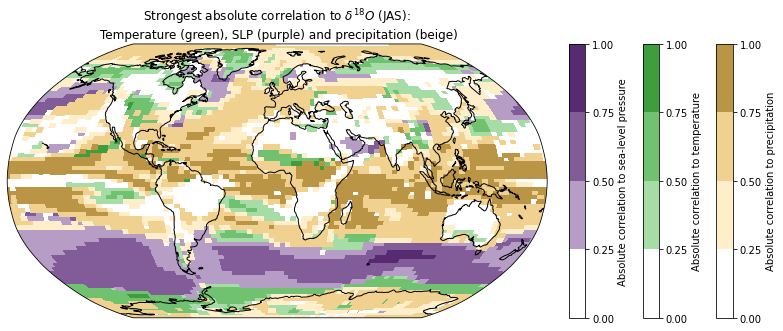

In [30]:
from numpy.ma import masked_array
  

# masked array to positive and negative values
tas_img = masked_array(max_cor_jas, np.invert(tas_mask_jas))
pr_img = masked_array(max_cor_jas, np.invert(pr_mask_jas))
slp_img = masked_array(max_cor_jas, np.invert(slp_mask_jas))
zero_img = masked_array(np.zeros_like(max_cor_jas), np.invert(not_incl_mask_jas))
  
# make plot
fig = plt.figure(figsize=(13,20))
ax = fig.add_subplot(111, projection = ccrs.Robinson())
ax.set_global()
# show image

cor_tas_field, lon_plot = add_cyclic_point(tas_img, coord = lon)
cor_pr_field, lon_plot = add_cyclic_point(pr_img, coord = lon)
cor_slp_field, lon_plot = add_cyclic_point(slp_img, coord = lon)
cor_zero_field, lon_plot = add_cyclic_point(zero_img, coord = lon)

lo, la = np.meshgrid(lon_plot, lat)
norm = matplotlib.colors.BoundaryNorm(np.linspace(0,1,5), 4)

colors_tas = ["#fff", "#A6DCA6", "#70C170", "#3E9E3E"]#, "#1E7F1E"]
cmap_tas= matplotlib.colors.ListedColormap(colors_tas)

colors_pr = ["#fff", "#FFEECA", "#F0D18F", "#BA9545"]#, "#866113"]
cmap_pr= matplotlib.colors.ListedColormap(colors_pr)

colors_slp = ["#fff", "#B59DC5", "#815C99", "#562B71"]#, "#2C0842"]
cmap_slp= matplotlib.colors.ListedColormap(colors_slp)

layer_tas = ax.pcolormesh(lo, la, cor_tas_field, transform=ccrs.PlateCarree(), cmap=cmap_tas, norm=norm)   
layer_slp = ax.pcolormesh(lo, la, cor_slp_field, transform=ccrs.PlateCarree(), cmap=cmap_slp, norm=norm)  
layer_pr = ax.pcolormesh(lo, la, cor_pr_field, transform=ccrs.PlateCarree(), cmap=cmap_pr, norm=norm)    
# layer_zero = ax.pcolormesh(lo, la, cor_zero_field, transform=ccrs.PlateCarree(), cmap=plt.cm.Greens, norm=norm)    
  

    
divider = make_axes_locatable(ax)


ax_cb1 = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
fig.add_axes(ax_cb1)
bar_slp = fig.colorbar(layer_slp, cax= ax_cb1, orientation='vertical')

ax_cb2 = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)
fig.add_axes(ax_cb2)
bar_tas = fig.colorbar(layer_tas, cax= ax_cb2, orientation='vertical')

ax_cb3 = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)
fig.add_axes(ax_cb3)
bar_pr = fig.colorbar(layer_pr, cax= ax_cb3, orientation='vertical')

bar_tas.set_label('Absolute correlation to temperature')
bar_pr.set_label('Absolute correlation to precipitation')
bar_slp.set_label('Absolute correlation to sea-level pressure')
ax.set_title("Strongest absolute correlation to $\delta^{18}O$ (JAS): \n Temperature (green), SLP (purple) and precipitation (beige)")
ax.coastlines()
plt.savefig("Images/Correlations_monthly_jas.png")
plt.savefig("Images/Correlations_monthly_jas.pdf")
plt.savefig("Images/Correlations_monthly_jas.jpg")
plt.show()
plt.close()